<a href="https://colab.research.google.com/github/miahong/Colonoscopy-AI/blob/master/colonoscopy_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import libraries and load Dataset - TODO : REMOVE UNUSED IMPORTS

In [1]:
# https://research.google.com/colaboratory/faq.html#drive-timeout
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import time
import copy
import os
import sys
import glob 
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, utils, datasets, models
from collections import OrderedDict
#%pip install livelossplot
#from livelossplot import PlotLossesKeras

In [3]:
def get_lib_versions():
  output = OrderedDict()
  output["Python version"] = sys.version.replace("\n", " ")
  output["Numpy version"] = np.version.full_version
  output["Pytorch version"] = torch.__version__
  output["Torchvision Version"] = torchvision.__version__
  for kv in output.items():
    print("%s: %s" % kv)

get_lib_versions()

Python version: 3.6.9 (default, Nov  7 2019, 10:44:02)  [GCC 8.3.0]
Numpy version: 1.18.3
Pytorch version: 1.5.0+cu101
Torchvision Version: 0.6.0+cu101


### Ensure reproducibility of results obtained using test data

In [0]:
torch.manual_seed(0)
np.random.seed(0)

### Dataset summary

In [0]:
# get both ungrouped AO and Non-AO image paths and check the total number of images
AO_folder_path = "/content/drive/My Drive/Colonoscopy-AI/data/model_data/AO/*"
NonAO_folder_path = "/content/drive/My Drive/Colonoscopy-AI/data/model_data/Non-AO/*"
AO_files = glob.glob(AO_folder_path)
NonAO_files = glob.glob(NonAO_folder_path)

# AO image original path
AO_img_path_list =[]
for file in AO_files:
    filename = os.path.basename(file)
    AO_img_path_list.append(file)

# Non AO image original path
NonAO_img_path_list =[]
for file in NonAO_files:
    filename = os.path.basename(file)
    NonAO_img_path_list.append(file)

# Read and Store Each Images and shapes
# AO image and shape
AO_img_list =[]
AO_img_shape_list =[]
for path in AO_img_path_list[0:1]:
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    AO_img_list.append(image)
    AO_img_shape_list.append(image.shape)
 
# Non-AO image and shape
NonAO_img_list =[]
NonAO_img_shape_list =[]
for path in NonAO_img_path_list[0:1]:
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    NonAO_img_list.append(image)
    NonAO_img_shape_list.append(image.shape)

# check unique shape size
# AO unique shape
AO_unique_shape_list =[]
for s in AO_img_shape_list:
    if s not in AO_unique_shape_list:
        AO_unique_shape_list.append(s)

# Non-AO unique shape
NonAO_unique_shape_list =[]
for s in NonAO_img_shape_list:
    if s not in NonAO_unique_shape_list:
        NonAO_unique_shape_list.append(s)

AO_count = len(AO_img_path_list)
NonAO_count = len(NonAO_img_path_list)
total_count = AO_count + NonAO_count
print ("AO images have shape: {}".format(AO_unique_shape_list))
print ("Non AO images have shape: {}".format(NonAO_unique_shape_list))
print ("Overall, {} AO images, {} Non AO images, giving a total of {} images.".format(AO_count, NonAO_count, total_count))

AO images have shape: []
Non AO images have shape: [(480, 736, 3)]
Overall, 0 AO images, 6673 Non AO images, giving a total of 6673 images.


### Data Loaders (train, val, test) - I MADE A CHANGE TO THE SHUFFLE PARAMETER FOR TEST(SEE SLACK)

In [0]:
# Hyper-parameters and parameters
BATCH_SIZE = 32
NUM_WORKER = 4

# Build transforms
data_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# Build the datasets
model_dataset = datasets.ImageFolder(root='/content/drive/My Drive/Colonoscopy-AI/data/model_data/', transform=data_transform)
print (len(model_dataset))

# Split the dataset into train, valid and test dataset
train_count = int(0.8 * total_count) 
valid_count = int((total_count - train_count)/2)
test_count = int((total_count - train_count)/2)
print('train, valid, test split count:{} {} {} '.format(train_count, valid_count, test_count))
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(model_dataset, (train_count, valid_count, test_count))

# Build Dataloader for these three datasets
train_dataset_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKER)
valid_dataset_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKER)
test_dataset_loader  = torch.utils.data.DataLoader(test_dataset , batch_size=BATCH_SIZE, shuffle=False,num_workers=NUM_WORKER)

# Create the dict for the dataloader
dataset_sizes = {'train': train_count, 'val': valid_count, 'test': test_count}
dataloaders = {'train': train_dataset_loader, 'val': valid_dataset_loader, 'test': test_dataset_loader}
print ("Dataloader have been built.")
print (dataset_sizes)

13250
train, valid, test split count:10600 1325 1325 
Dataloader have been built.
{'train': 10600, 'val': 1325, 'test': 1325}


### Initialize the model and optimizer and loss function - CHANGE OPTIMIZER TO ADAM, MODEL TO DENSENET 

In [0]:
# Hyper-parameters and parameters
feature_extract = True 
num_classes = 2
use_pretrained = True
LEARNING_RATE = 0.001
MOMENTUM = 0.9
STEP_SIZE = 7
GAMMA = 0.1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize the model        
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

# This function will need to be changed for different models.
def initialize_model(num_classes, feature_extract, use_pretrained=True):
    model_ft = models.resnet18(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    input_size = 224
    return model_ft, input_size

model_ft, input_size = initialize_model(num_classes, feature_extract, use_pretrained)
model_ft = model_ft.to(device) 

# Initialize the optimizer
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

optimizer_ft = optim.SGD(params_to_update, lr=LEARNING_RATE, momentum=MOMENTUM)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=STEP_SIZE, gamma=GAMMA)

# Initialize the loss function
criterion = nn.CrossEntropyLoss()

# Check whether you are on GPU or CPU
print (device)

Params to learn:
	 fc.weight
	 fc.bias
cuda:0


### Train the model (train and val datasets)

In [0]:
# TODO : https://github.com/stared/livelossplot (Plot the loss and accuracy as the training happens)
# reference to https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#training-the-model

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train','val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode for validation phase

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        train_losses.append(loss.item())                        ## TODO : change this so that we save only every 10 batches
                    if phase == 'val':
                        val_losses.append(loss.item())

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))    
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses

Epoch 0/49
----------
train Loss: 0.4534 Acc: 0.7894
val Loss: 0.4302 Acc: 0.8181

Epoch 1/49
----------
train Loss: 0.4029 Acc: 0.8198
val Loss: 0.3546 Acc: 0.8521

Epoch 2/49
----------
train Loss: 0.3958 Acc: 0.8258
val Loss: 0.3652 Acc: 0.8475

Epoch 3/49
----------
train Loss: 0.3831 Acc: 0.8326
val Loss: 0.3703 Acc: 0.8453

Epoch 4/49
----------
train Loss: 0.3823 Acc: 0.8327
val Loss: 0.3417 Acc: 0.8536

Epoch 5/49
----------
train Loss: 0.3791 Acc: 0.8316
val Loss: 0.3560 Acc: 0.8385

Epoch 6/49
----------
train Loss: 0.3696 Acc: 0.8378
val Loss: 0.3691 Acc: 0.8423

Epoch 7/49
----------
train Loss: 0.3675 Acc: 0.8407
val Loss: 0.3641 Acc: 0.8423

Epoch 8/49
----------
train Loss: 0.3571 Acc: 0.8445
val Loss: 0.3556 Acc: 0.8506

Epoch 9/49
----------
train Loss: 0.3622 Acc: 0.8406
val Loss: 0.3413 Acc: 0.8543

Epoch 10/49
----------
train Loss: 0.3606 Acc: 0.8402
val Loss: 0.3446 Acc: 0.8536

Epoch 11/49
----------
train Loss: 0.3596 Acc: 0.8391
val Loss: 0.3338 Acc: 0.8581

Ep

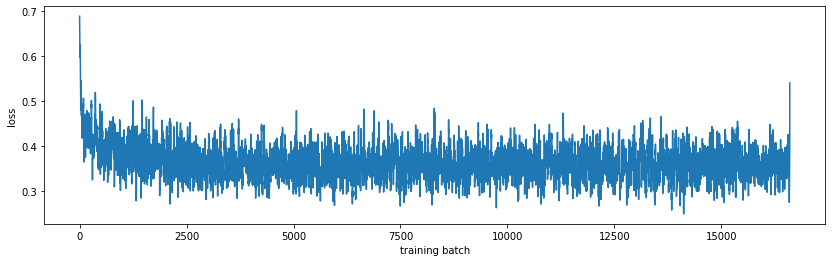

In [0]:
# Hyper-parameter
N_EPOCHS = 50

model_ft, losses, _ = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=N_EPOCHS)

def mean(li): 
    return sum(li)/len(li)
      
plt.figure(figsize=(14, 4))
plt.xlabel('training batch') # TODO : choose a better name for this
plt.ylabel('loss')
plt.plot([mean(losses[i:i+10]) for i in range(len(losses))])

### Test the trained model (test dataset) - SEE COMMENT ON THE LINE WHERE 12 WAS WRITTEN INSTEAD OF BATCH SIZE LAST FRIDAY


In [0]:
def test_model(model, criterion):
    since = time.time()

    class_correct = list(0. for i in range(num_classes))
    class_total = list(0. for i in range(num_classes))

    y_true = []
    y_pred = []

    classes = []
    classes.append(0)
    classes.append(1)

    correct = 0
    total = 0

    model.to(device) 
    model.eval()   # Set model to evaluate mode for testing phase

    with torch.no_grad():
      # Iterate over all the batches of data in test dataloader
      for inputs, labels in dataloaders['test']:
          inputs = inputs.to(device)
          labels = labels.to(device) ## y_true

          outputs = model(inputs)
          _, preds = torch.max(outputs, 1) ## y_pred

          # Calculating accuracy on test-data.
          total += labels.size(0)
          correct += (preds == labels).sum().item()

          # Calculating per-class accuracy for this batch of data. 
          c = (preds == labels).squeeze()
          for i in range(12):                                                     # SHOULD WE REPLACE 12 BY len(labels)? MOST PROBABLY, YES. TRY AND SEE WHAT HAPPENS.
              label = labels[i]
              class_correct[label] += c[i].item()
              class_total[label] += 1

          # Probably need to bring all tensors (labels, preds) to CPU first for sklearn metrics to work properly,
          # as it is a different framework than PyTorch and may not be able to handle cuda tensors always.
 
          ## not really sure about the necessity of the next 2 lines 
          y_pred.append(outputs.cpu())
          y_true.append(labels.cpu().numpy())

    # Printing per-class accuracy of the trained classifier (for test data).
    for i in range(2):
      print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

    # Printing the overall test accuracy.
    print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

    time_elapsed = time.time() - since
    print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return y_true, y_pred

In [0]:
y_true, y_pred = test_model(model_ft, criterion)

## TODO : use scikit-learn metrics for binary classification (https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics)
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, roc_auc_score

# calculate_metric(y_true, y_pred) for all metrics you need over here

Accuracy of     0 : 85 %
Accuracy of     1 : 82 %
Accuracy of the network on the test images: 83 %
Testing complete in 0m 12s


### General overview of steps involved in this task

Useful links: <br>

https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html <br>
https://discuss.pytorch.org/t/getting-the-proper-prediction-and-comparing-it-to-the-true-value/16468/3<br>
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html<BR>
https://www.learnopencv.com/pytorch-for-beginners-image-classification-using-pre-trained-models/<br>
http://bytepawn.com/solving-mnist-with-pytorch-and-skl.html<br>
https://gist.github.com/SuperShinyEyes/dcc68a08ff8b615442e3bc6a9b55a354<br>

```python
## HYPER-PARAMETERS AND PARAMETERS
feature_extract = True 
num_classes = 2
use_pretrained = True
N_EPOCHS = 1
LEARNING_RATE = 0.001
MOMENTUM = 0.9
STEP_SIZE = 7
GAMMA = 0.1
BATCH_SIZE = 32
NUM_WORKER = 4
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## DATALOADERS
dataloaders = {'train': train_dataset_loader, 'valid': valid_dataset_loader, 'test': test_dataset_loader}

## INITIALIZE MODEL		# executed on CPU
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(num_classes, feature_extract, use_pretrained=True):
    model_ft = models.resnet18(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    input_size = 224
    return model_ft, input_size

model_ft, input_size = initialize_model(num_classes, feature_extract, use_pretrained)
model_ft = model_ft.to(device) # sends model to GPU

## INITIALIZE OPTIMIZER  # don't need to send this to GPU
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9) 
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size = STEP_SIZE, gamma=GAMMA)

## INITIALIZE THE LOSS FUNCTION  # don't need to send this to GPU
criterion = nn.CrossEntropyLoss()

## TRAIN THE MODEL AND VALIDATE
def train_model(...)	# sends data to GPU
	...

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=N_EPOCHS)

## TEST THE TRAINED MODEL
def test_model(...)
	...

## SAVE THE MODEL WEIGHTS
def save_model(...)
	...

## LOAD THE MODEL AND USE IT FOR PREDICTING IN REAL-TIME
def load_model(...)
	...
```